In [89]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from matplotlib import pyplot as plt
%matplotlib inline 
xp = cuda.cupy
import time


def model_func(model):
    if xp == np:
        pass
    else :
        gpu_device = 0
        cuda.get_device(gpu_device).use()
        model.to_gpu(gpu_device)
xp.model_init = model_func

In [104]:
def make_f(N=100):
    t = 0
    p = None
    w = None
    r = None
    p2 = None
    w2 = None
    r2 = None
    
    def rst():
        nonlocal p,w,r
        p = xp.random.rand(N) * 100
        w = xp.random.rand(N) * 2 + 1
        r = xp.random.rand(N) * 0 + 1
    rst()
    
    def next():
        nonlocal t
        t += 0.1
        a = xp.random.rand(N)
        return Variable( a.reshape(-1,1).astype(xp.float32) )
    return (next,rst)
(f,f_rst) = make_f()

In [105]:
f_rst()
li = []
for i in range(300):
    li.append( cuda.to_cpu( f().data[0] ) )
li = np.array(li).flatten()

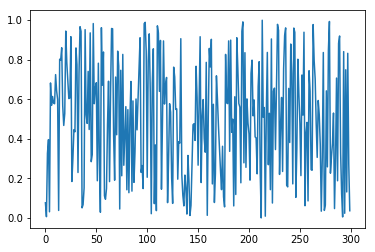

In [106]:
plt.plot(li)

In [109]:
class RNN(Chain):
    def __init__(this):
        N = 100
        super().__init__(
            fst=L.Linear(1,N),
            mid=L.LSTM(N, N),  
            out=L.Linear(N, 1),  
        )

    def reset_state(this):
        this.mid.reset_state()

    def __call__(this, x):
        g = this.fst(x)
        h = this.mid(g)
        y = this.out(h)
        return y 

class CSR(Chain):
    def __init__(this,pred):
        super().__init__(
            pred = pred
        )

    def reset_state(this):
        this.pred.reset_state()

    def __call__(this, x, t):
        return F.mean_squared_error(this.pred(x),t)
    
    
rnn = RNN()
model = CSR(rnn)

xp.model_init(model)

optimizer = optimizers.Adam()
optimizer.setup(model)

In [110]:
loss = 0
count = 0
dep = 100
stp = 1000
prt = 100

start = time.time()

rnn.reset_state()
t = f()
for i in range(stp*dep):
    count += 1
    
    x = t
    t = f()
    
    tmp = model(x,t)
    if count % dep > 20:
        loss += tmp
   
    if  (count) % dep == 0:
        model.cleargrads()
        loss.backward()
        loss.unchain_backward()
        optimizer.update()
    
        if ((i//dep)%prt == 0):
            print ("{},{}".format(i//dep,loss.data))
        loss = 0
        
    #if ( i % int(dep * 20) == 0 ):
        f_rst() #!!! DO NOT RESET MANY TIMES !!!
        #print ("RST")
        rnn.reset_state()
        
end = time.time()
print ("TIME COST:{}".format(end-start))
        

0,36.71038818359375
100,6.612889766693115
200,6.5955095291137695
300,6.572956562042236
400,6.498614311218262
500,6.688073635101318
600,6.664966583251953
700,6.708920955657959
800,6.5104289054870605
900,6.536530017852783
TIME COST:296.54729652404785


In [115]:
rnn.reset_state()
f_rst()

pre = 500
prd = 500

liy = []
lit = []
x = f()
for i in range (prd + pre):
    y = rnn(x)
    t = f()
    
    liy.append(cuda.to_cpu(y.data[0:1]))
    lit.append(cuda.to_cpu(t.data[0:1]))
    
    if i < pre :
        x = t
    else:
        x = y
liy = np.array(liy).flatten()
lit = np.array(lit).flatten()


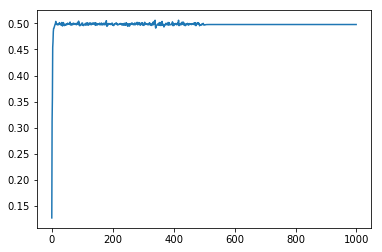

In [116]:
plt.plot(liy)
#plt.plot(lit)

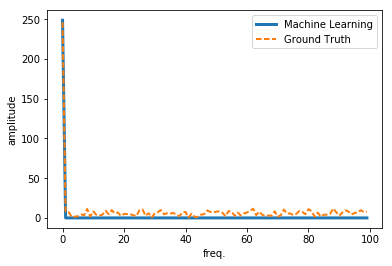

In [113]:
fy = np.fft.fft(liy[pre:])
ft = np.fft.fft(lit[pre:])
fy = np.abs(fy)
ft = np.abs(ft)
plt.plot(fy[:100],linewidth = 3)
plt.plot(ft[:100],"--",linewidth =2)
plt.legend(["Machine Learning","Ground Truth"])
plt.xlabel("freq.")
plt.ylabel("amplitude")

In [114]:
-1 % 10

9